<a href="https://colab.research.google.com/github/KalikaKay/Author-Classification-Project/blob/master/RNN_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN Modeling

Use an RNN deep learning model to perform classification.

# Data Cleaning



In [4]:
import matplotlib.pyplot as plt
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import MinMaxScaler
from gensim.models import Word2Vec
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from gensim.summarization import keywords
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import datetime as dt
from sklearn.metrics import classification_report
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
import numpy as np

# file location
PATH = '/content/drive/MyDrive/Author Classification/AuthorTexts'
DOC_PATTERN = r'.*\.txt'

corpus = PlaintextCorpusReader(PATH, DOC_PATTERN)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
#Dataframe of sentences and authors.
for fileid in corpus.fileids():
  book = pd.DataFrame(corpus.raw(fileids=fileid).split('\n'), columns=['sentence'])
  book['author'] = fileid.split('/')[0]
  try:
    books = pd.concat([books, book])
  except NameError: 
    books = book

In [6]:
#Remove empty strings.
books = books.replace(r'^\s*$', np.NaN, regex=True)
books.dropna(inplace=True)
books.reindex()

#Remove contents and Chapter Titles.
i = 0
for sent in books.sentence:
  if any(c.islower() for c in sent) == False:
    books.iloc[i] = np.NaN
  if 'project gutenberg' in sent.lower():
    books.iloc[i] = np.NaN    
  if 'contents' == sent.lower().strip():
    books.iloc[i] == np.NaN
  i += 1

books.dropna(inplace=True)
books.reindex()
#drop the content headers.
content_index = books[books.sentence == 'Contents '].index.values
books.drop(content_index, inplace=True)

# Feature Engineering

In [49]:
#Tokenize the data
tokenizer = RegexpTokenizer(r'\w+')
books['tokenized'] = [tokenizer.tokenize(sent.lower()) for sent in books.sentence 
                   if tokenizer.tokenize(sent.lower()) not in stopwords.words('english')]

# Lemmatize the tokens. 
lemmatizer = WordNetLemmatizer()
lemmatized = []
for token in books.tokenized:
  lemmatized.append(' '.join([lemmatizer.lemmatize(word) for word in token]))
books['lemmatized'] = lemmatized

In [50]:
y = books['author']
#number of categorical variables.
y.nunique()

9

In [51]:
# Encode the documents.
enc = books.lemmatized.apply(one_hot, args=[5000])
X = pad_sequences(enc)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
#Ordinal encode and translate the target variable to categorical.
oec = OrdinalEncoder()
y_train = oec.fit_transform(y_train.values.reshape(-1,1))
y_test = oec.transform(y_test.values.reshape(-1,1))

In [54]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [55]:
#Reviewing the shape of the data.
print( X_train.shape, y_train.shape,
      X_test.shape, y_test.shape) 

(18498, 2247) (18498, 9) (4625, 2247) (4625, 9)


#Modeling

Basic Model

In [23]:
from tensorflow.keras.layers import LSTM, Embedding, Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

model = Sequential()

# input layer
model.add(Input(shape=(X_train.shape[1]), name='word_input' ))

# embedding layer
model.add(Embedding(5000, 100, input_length=(X_train.shape[1]), name='word_embed'))

# lstm layer
model.add(LSTM(32, name='word_lstm'))

# dense layer
model.add(Dense(32, activation='relu', name='word_hidden_1'))

#output layer
model.add(Dense(9, activation='softmax', name='output'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embed (Embedding)       (None, 2247, 100)         500000    
_________________________________________________________________
word_lstm (LSTM)             (None, 32)                17024     
_________________________________________________________________
word_hidden_1 (Dense)        (None, 32)                1056      
_________________________________________________________________
output (Dense)               (None, 9)                 297       
Total params: 518,377
Trainable params: 518,377
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size=16, epochs=10)

Epoch 1/10
1157/1157 [==============================] - 83s 71ms/step - loss: 0.1339 - accuracy: 0.9570 - val_loss: 0.9353 - val_accuracy: 0.7955
Epoch 2/10
1157/1157 [==============================] - 83s 71ms/step - loss: 0.1226 - accuracy: 0.9613 - val_loss: 1.0011 - val_accuracy: 0.7961
Epoch 3/10
1157/1157 [==============================] - 82s 71ms/step - loss: 0.0863 - accuracy: 0.9736 - val_loss: 1.0425 - val_accuracy: 0.7875
Epoch 4/10
1157/1157 [==============================] - 82s 71ms/step - loss: 0.0721 - accuracy: 0.9780 - val_loss: 1.0887 - val_accuracy: 0.7911
Epoch 5/10
1157/1157 [==============================] - 82s 71ms/step - loss: 0.0795 - accuracy: 0.9763 - val_loss: 1.1882 - val_accuracy: 0.7868
Epoch 6/10
1157/1157 [==============================] - 81s 70ms/step - loss: 0.0613 - accuracy: 0.9811 - val_loss: 1.2287 - val_accuracy: 0.7901
Epoch 7/10
1157/1157 [==============================] - 81s 70ms/step - loss: 0.0536 - accuracy: 0.9830 - val_loss: 1.3181 -

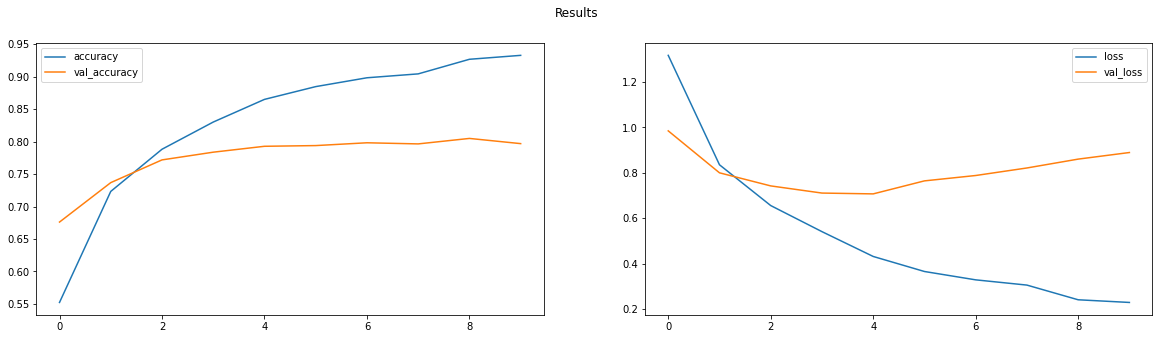

In [27]:
results = pd.DataFrame(history.history)

#Split the count plot.
f, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,5))
plt.suptitle('Results')
results[['accuracy', 'val_accuracy']].plot(ax=ax1)
results[['loss', 'val_loss']].plot(ax=ax2)
plt.show()

I can see that the accuracy score is neither is starting to decrease around epoch 10, so increasing the number of epochs is not necessary.

My model is overfitting - the training data is outperforming the validation data by twenty points, on average and while the training data continues to improve, the validation data? Is starting to see a decreates.

With regards to loss; I can see a very significant increase in loss on my validation data as I approach the second fifth epoch. 

The desire is a higher accuracy. To acheive the better accuracy; look to minimize the loss. 

*Note: a few runs were done with this prior to deciding on this default/basic model for evaluating. I've decided/determined that I should proceed with a batch count of 16. If you should try this model, I recommennd experimenting with a size 10 batch size. It's interesting.*

## Tuning

Using a few techniques to tune the fit.

In [28]:

model = Sequential()

# input layer
model.add(Input(shape=(X_train.shape[1]), name='word_input' ))

# embedding layer
model.add(Embedding(5000, 100, input_length=(X_train.shape[1]), name='word_embed'))

# lstm layer
model.add(LSTM(64, name='word_lstm'))

#add dropout layer
model.add(Dropout(.3))

# increase dense layer dim
model.add(Dense(64, activation='relu', name='word_hidden_1'))

# decrease dense layer dim
model.add(Dense(32, activation='relu', name='word_hidden_2'))

#output layer
model.add(Dense(9, activation='softmax', name='output'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embed (Embedding)       (None, 2247, 100)         500000    
_________________________________________________________________
word_lstm (LSTM)             (None, 64)                42240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
word_hidden_1 (Dense)        (None, 64)                4160      
_________________________________________________________________
word_hidden_2 (Dense)        (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 9)                 297       
Total params: 548,777
Trainable params: 548,777
Non-trainable params: 0
________________________________________________

In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size=16, epochs=10)


Epoch 1/10
1157/1157 [==============================] - 87s 74ms/step - loss: 1.4772 - accuracy: 0.4855 - val_loss: 0.9874 - val_accuracy: 0.6629
Epoch 2/10
1157/1157 [==============================] - 85s 74ms/step - loss: 0.8130 - accuracy: 0.7240 - val_loss: 0.7427 - val_accuracy: 0.7561
Epoch 3/10
1157/1157 [==============================] - 85s 74ms/step - loss: 0.6305 - accuracy: 0.7999 - val_loss: 0.7024 - val_accuracy: 0.7790
Epoch 4/10
1157/1157 [==============================] - 85s 74ms/step - loss: 0.4524 - accuracy: 0.8577 - val_loss: 0.7200 - val_accuracy: 0.7810
Epoch 5/10
1157/1157 [==============================] - 85s 74ms/step - loss: 0.4064 - accuracy: 0.8740 - val_loss: 0.7471 - val_accuracy: 0.7963
Epoch 6/10
1157/1157 [==============================] - 85s 74ms/step - loss: 0.2912 - accuracy: 0.9096 - val_loss: 0.7781 - val_accuracy: 0.7846
Epoch 7/10
1157/1157 [==============================] - 85s 74ms/step - loss: 0.2462 - accuracy: 0.9246 - val_loss: 0.8585 -

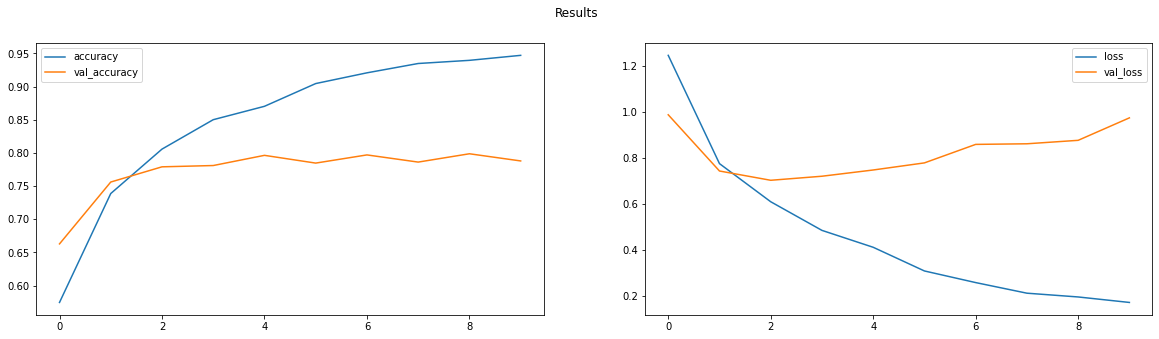

In [31]:
results = pd.DataFrame(history.history)

#Split the count plot.
f, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,5))
plt.suptitle('Results')
results[['accuracy', 'val_accuracy']].plot(ax=ax1)
results[['loss', 'val_loss']].plot(ax=ax2)
plt.show()

The accuracy score seems to waiver around 78 with this model. 

As with the other solution, there's an increase in validation loss with each epoch.

In [71]:

model = Sequential()

# input layer
model.add(Input(shape=(X_train.shape[1]), name='word_input' ))

# embedding layer
model.add(Embedding(5000, 100, input_length=(X_train.shape[1]), name='word_embed'))

# lstm layer
model.add(LSTM(64, name='word_lstm'))

# increase dense layer dim
model.add(Dense(32, activation='relu'))

# decrease dense layer dim
model.add(Dense(32, activation='relu'))

model.add(Dropout(0.1))

# decrease dense layer dim
model.add(Dense(16, activation='relu'))

#output layer
model.add(Dense(9, activation='softmax'))

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embed (Embedding)       (None, 2247, 100)         500000    
_________________________________________________________________
word_lstm (LSTM)             (None, 64)                42240     
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_25 (Dense)             (None, 9)               

Epoch 1/5
579/579 [==============================] - 55s 92ms/step - loss: 0.0911 - accuracy: 0.9713 - val_loss: 1.3022 - val_accuracy: 0.7920
Epoch 2/5
579/579 [==============================] - 52s 90ms/step - loss: 0.0640 - accuracy: 0.9788 - val_loss: 1.3542 - val_accuracy: 0.7801
Epoch 3/5
579/579 [==============================] - 52s 90ms/step - loss: 0.0546 - accuracy: 0.9827 - val_loss: 1.3973 - val_accuracy: 0.7799
Epoch 4/5
579/579 [==============================] - 52s 90ms/step - loss: 0.0532 - accuracy: 0.9834 - val_loss: 1.5779 - val_accuracy: 0.7903
Epoch 5/5
579/579 [==============================] - 52s 90ms/step - loss: 0.0417 - accuracy: 0.9863 - val_loss: 1.6368 - val_accuracy: 0.7875


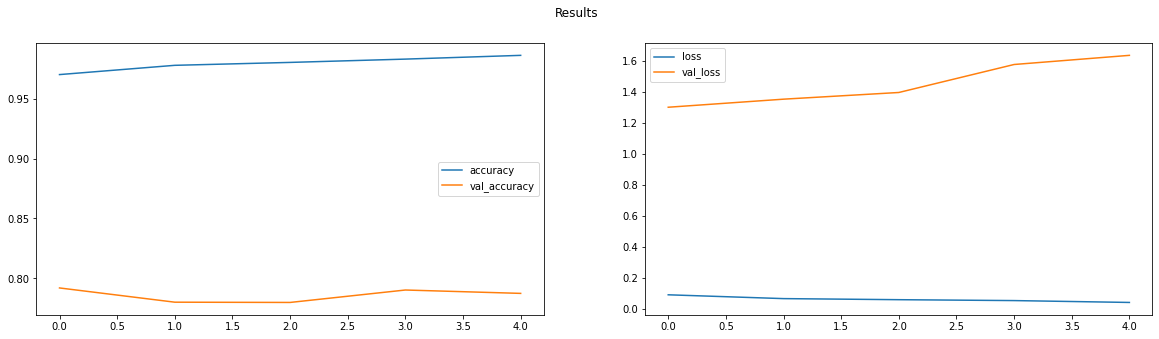

In [75]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size=32, epochs=5)

results = pd.DataFrame(history.history)

#Split the count plot.
f, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,5))
plt.suptitle('Results')
results[['accuracy', 'val_accuracy']].plot(ax=ax1)
results[['loss', 'val_loss']].plot(ax=ax2)
plt.show()

In [79]:
list(oec.categories_[0])

['Anne Bronte',
 'Bell AKA Bronte Sisters',
 'Charlotte Bronte',
 'Edith Rickert & Gleb Botkin',
 'Emily Bronte',
 'Ethel M. Dell',
 'Fyodor Dostoevsky',
 'Jane Austen',
 'Various']

In [80]:
# get the predictions against the test dataset as whole numbers.
pred = model.predict(X_test)
predicted_class_indices=np.argmax(pred,axis=-1) 
# revert the categorical data into ordinal data. 
y_true = [np.argmax(n) for n in y_test]

print(classification_report(y_true, 
                            predicted_class_indices,
                            target_names=list(oec.categories_[0])))

                             precision    recall  f1-score   support

                Anne Bronte       0.51      0.46      0.48       177
    Bell AKA Bronte Sisters       0.77      0.75      0.76       161
           Charlotte Bronte       0.36      0.38      0.37        13
Edith Rickert & Gleb Botkin       0.72      0.62      0.67        29
               Emily Bronte       0.68      0.67      0.67       426
              Ethel M. Dell       0.87      0.85      0.86      1737
          Fyodor Dostoevsky       0.75      0.82      0.79      1118
                Jane Austen       0.84      0.78      0.81       529
                    Various       0.73      0.72      0.73       435

                   accuracy                           0.79      4625
                  macro avg       0.69      0.67      0.68      4625
               weighted avg       0.79      0.79      0.79      4625



# Conclusion

After a number of iterations, trials and errors, I conclude that the RNN modeling is not ideal for this classification project. 

I receive the fastest and most accurate results with a bag of words on Naive Bayes model. 

---
*a Thinkful Project by Kalika Kay Curry*
